In [146]:
%matplotlib widget
from IPython.display import clear_output
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import polars as pl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error as mse
plt.ion()

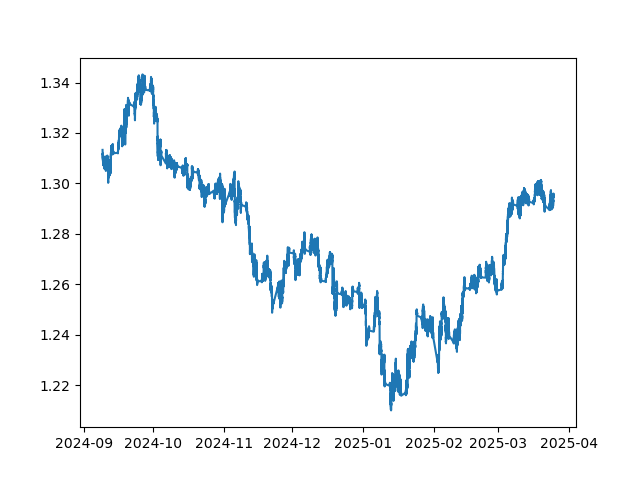

(3356, 1) (3356, 1)


In [197]:
fileName = "GBPUSD_M1.csv"
data = pd.read_csv(fileName)

priceData = pl.DataFrame(data[["Time", "Close"]]).select([
    pl.col("Time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M"),
    pl.col("Close")
])
priceData = (
    priceData.sort(by="Time")
    .drop_nulls()
)
timeSeriesM = priceData.select(pl.col("Time").dt.timestamp()).to_numpy()
priceSeriesM = priceData.select(pl.col("Close")).to_numpy()

priceData = (
    priceData.group_by_dynamic("Time", every="1h")
    .agg(pl.col("Close").median())
)

timeSeries = priceData.select(pl.col("Time").dt.timestamp()).to_numpy()
priceSeries = priceData.select(pl.col("Close")).to_numpy()


fig = plt.figure(fileName)
plt.clf()
plt.plot([datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeriesM[:,0]],priceSeriesM)
plt.title("")
plt.show()

print(timeSeries.shape, priceSeries.shape)

In [ ]:
def plotGPR(timeSeries, meanSeries, stdSeries, onlyLatestValue):
    if onlyLatestValue: 
        color = 'darkorange'
        label1 = 'Predicted Mean'
        label2 = 'Predicted 95% Confidence'
    else: 
        color = 'darkgreen'
        label1 = 'True Mean'
        label2 = 'True 95% Confidence'
    
    plt.scatter([datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeries], meanSeries,color= color, label= label1)
    plt.fill_between(
        [datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeries],
        meanSeries - 1.96 * stdSeries,
        meanSeries + 1.96 * stdSeries,
        alpha=0.5,
        color= color,
        label= label2
    )
    date_format = mdates.DateFormatter('%b %d')
    plt.gcf().axes[0].xaxis.set_major_formatter(date_format)
    plt.legend()
    


In [200]:

def gprPredict(start, window, onlyLatestValue):
    projectSamples = 0


    
    X = timeSeries[start-window:start,0].reshape(-1,1)
    y = priceSeries[start-window:start,0]


    yMean = y.mean()
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=1)
    gpr.fit(X, y-yMean)

    if onlyLatestValue: Xtest = X[-1].reshape(1,-1)
    else: Xtest = X

    print(Xtest.shape)

    meanPred, stdPred = gpr.predict(Xtest, return_std=True)
    meanPred += yMean

    if onlyLatestValue: return np.array([[Xtest[-1, 0], meanPred[0], stdPred[0]]])

       
    else: return #np.column_stack((Xtest, meanPred, stdPred))


All tests computed with no errors.


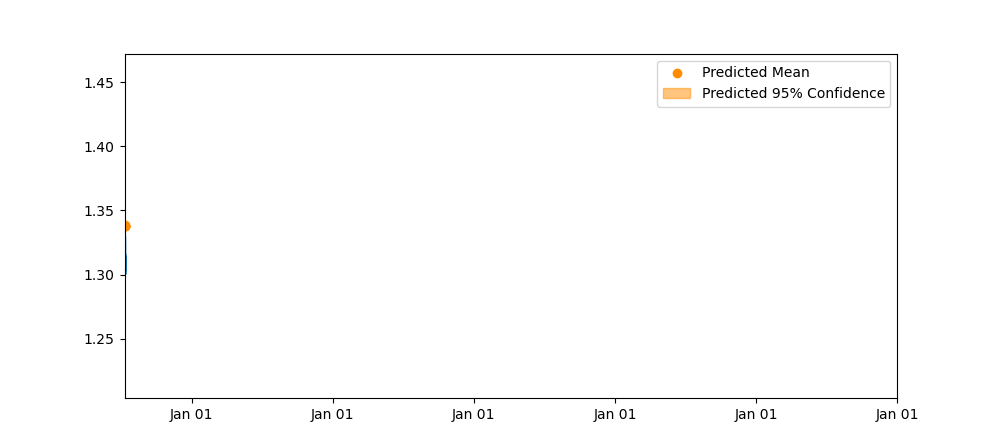

In [204]:

# Backtest the GPR function.

startTime = -3000 # Number of hours in history
n = 100 # Number of samples to process per GPR
testRange = 5 # Number of GPR tests to conduct over time

predictSeries = gprPredict(startTime, n, True)
for i in range(1, testRange):
    predictSeries = np.vstack((predictSeries, gprPredict(startTime+i, n, True)))
    clear_output(wait=True)
    print(f"{i}/{testRange} tests computed...")
clear_output(wait=True)   
print("All tests computed with no errors.")

#trueSeries = gprPredict(startTime+testRange-1, n, False)
#trueSeries = trueSeries[-testRange:]

#predictMSE = [mse(predictSeries[:,1], trueSeries[:,1]),mse(predictSeries[:,2], trueSeries[:,2])]
#print("MSE[mean,std]: ", predictMSE)

fig = plt.figure(2)
plt.clf()
plotGPR(predictSeries[:,0], predictSeries[:,1], predictSeries[:,2], True)
#plotGPR(trueSeries[:,0], trueSeries[:,1], trueSeries[:,2], False)

plt.plot([datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeriesM[:,0]],priceSeriesM)

plt.xlim(datetime.fromtimestamp(predictSeries[0,0]/1e6),datetime.fromtimestamp(predictSeries[0,-1]/1e6))


plt.show()
